In [ ]:
# Модифицируйте существующую линейную регрессию:
# - Добавьте L1 и L2 регуляризацию
# - Добавьте early stopping

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from utils import make_regression_data, log_epoch, RegressionDataset

class LinearRegression(nn.Module):
    def __init__(self, in_features, l1_lambda=0.01, l2_lambda=0.01):
        super().__init__()
        self.linear = nn.Linear(in_features, 1)
        self.l1_lambda = l1_lambda
        self.l2_lambda = l2_lambda
        
    def forward(self, x):
        return self.linear(x)
    
    def regularization_loss(self):
        #Вычисляет сумму L1 и L2
        l1_loss = sum(p.abs().sum() for p in self.parameters())
        l2_loss = sum(p.pow(2).sum() for p in self.parameters())
        return self.l1_lambda * l1_loss + self.l2_lambda * l2_loss

def train_with_early_stopping(model, dataloader, criterion, optimizer, 
                              epochs=100, patience=5, delta=0.001):
    #Обучение с остановкой
    best_loss = float('inf')
    patience_counter = 0
    
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        
        for i, (batch_X, batch_y) in enumerate(dataloader):
            optimizer.zero_grad()
            y_pred = model(batch_X)
            
            # Основная потеря + регуляризация
            loss = criterion(y_pred, batch_y) + model.regularization_loss()
            
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_loss = total_loss / (i + 1)
        
        # Логирование каждые 10 эпох
        if epoch % 10 == 0:
            log_epoch(epoch, avg_loss)
        
        # Ранняя остановка
        if avg_loss < best_loss - delta:
            best_loss = avg_loss
            patience_counter = 0
            # Сохраняем лучшие веса
            torch.save(model.state_dict(), 'best_linreg.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Ранняя остановка на эпохе {epoch}")
                break
                
    return model

if __name__ == '__main__':
    # Генерируем данные
    X, y = make_regression_data(n=200)
    
    # Создаём датасет и даталоадер
    dataset = RegressionDataset(X, y)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
    
    # Создаём модель с регуляризацией
    model = LinearRegression(in_features=1, l1_lambda=0.01, l2_lambda=0.01)
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1)
    
    # Обучаем модель с ранней остановкой
    model = train_with_early_stopping(
        model, 
        dataloader, 
        criterion, 
        optimizer,
        patience=10,
        delta=0.0001
    )
    import os
    os.makedirs('models', exist_ok=True)
    # Сохраняем финальную модель
    torch.save(model.state_dict(), 'models/linreg_torch.pth')
    new_model = LinearRegression(in_features=1)
    new_model.load_state_dict(torch.load('models/linreg_torch.pth'))

Epoch 10: loss=0.1156
Epoch 20: loss=0.0826
Epoch 30: loss=0.0779
Epoch 40: loss=0.0792
Ранняя остановка на эпохе 44


In [ ]:
# Модифицируйте существующую логистическую регрессию:
# - Добавьте поддержку многоклассовой классификации
# - Реализуйте метрики: precision, recall, F1-score, ROC-AUC
# - Добавьте визуализацию confusion matrix

Epoch 10: loss=0.4742, acc=0.9196, precision=0.7619, recall=0.7550, f1=0.7579, auc=-0.9133
Epoch 20: loss=0.3475, acc=0.9286, precision=0.9396, recall=0.9117, f1=0.9227, auc=-0.9910
Epoch 30: loss=0.2824, acc=0.9554, precision=0.9517, recall=0.9296, f1=0.9390, auc=-0.9937
Epoch 40: loss=0.2642, acc=0.9598, precision=0.9566, recall=0.9416, f1=0.9481, auc=-0.9945
Epoch 50: loss=0.2471, acc=0.9464, precision=0.9629, recall=0.9560, f1=0.9592, auc=-0.9950
Epoch 60: loss=0.2161, acc=0.9688, precision=0.9632, recall=0.9578, f1=0.9604, auc=-0.9954
Epoch 70: loss=0.2104, acc=0.9688, precision=0.9676, recall=0.9618, f1=0.9645, auc=-0.9957
Epoch 80: loss=0.2043, acc=0.9509, precision=0.9634, recall=0.9589, f1=0.9611, auc=-0.9959
Epoch 90: loss=0.1871, acc=0.9688, precision=0.9626, recall=0.9584, f1=0.9604, auc=-0.9961
Epoch 100: loss=0.1890, acc=0.9643, precision=0.9611, recall=0.9573, f1=0.9591, auc=-0.9962


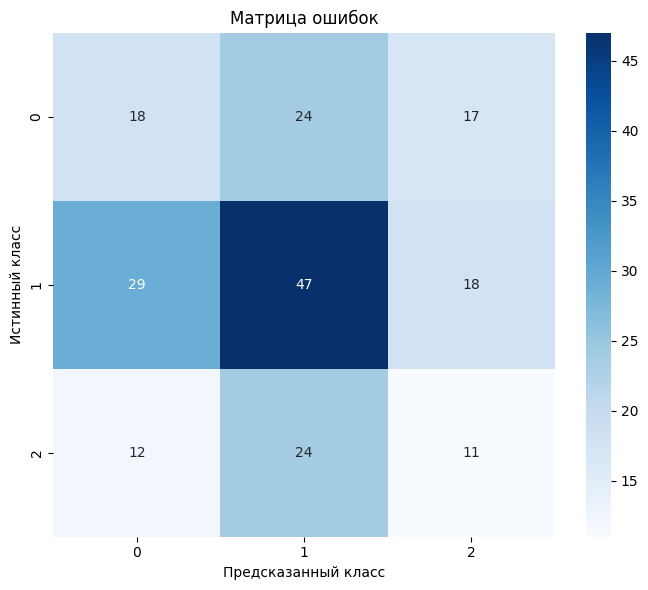

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import seaborn as sns
from utils import log_epoch, ClassificationDataset

#Модель
class LogisticRegression(nn.Module):
    def __init__(self, in_features, n_classes=2):
        super().__init__()
        self.n_classes = n_classes
        self.linear = nn.Linear(in_features, n_classes if n_classes > 2 else 1)

    def forward(self, x):
        return self.linear(x)

# Создание метрик
def accuracy(y_pred, y_true):
    if y_pred.ndim > 1 and y_pred.shape[1] > 1:
        y_pred_labels = torch.argmax(y_pred, dim=1)
    else:
        y_pred_labels = (y_pred > 0.5).long().squeeze()
    return (y_pred_labels == y_true).float().mean().item()

def multiclass_precision_recall_f1(y_true, y_pred, n_classes):
    precision_list, recall_list, f1_list = [], [], []
    y_true = torch.tensor(y_true)
    y_pred = torch.tensor(y_pred)

    for cls in range(n_classes):
        TP = ((y_pred == cls) & (y_true == cls)).sum().item()
        FP = ((y_pred == cls) & (y_true != cls)).sum().item()
        FN = ((y_pred != cls) & (y_true == cls)).sum().item()

        precision = TP / (TP + FP + 1e-8)
        recall = TP / (TP + FN + 1e-8)
        f1 = 2 * precision * recall / (precision + recall + 1e-8)

        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

    return sum(precision_list)/n_classes, sum(recall_list)/n_classes, sum(f1_list)/n_classes

def multiclass_roc_auc(y_true, y_probs, n_classes, thresholds=100):
    y_true = torch.tensor(y_true)
    y_probs = torch.tensor(y_probs)
    auc_list = []

    for cls in range(n_classes):
        y_true_bin = (y_true == cls).long()
        y_prob_cls = y_probs[:, cls]

        tpr_list, fpr_list = [], []
        for thresh in torch.linspace(0, 1, thresholds):
            y_pred_bin = (y_prob_cls >= thresh).long()
            TP = ((y_pred_bin == 1) & (y_true_bin == 1)).sum().item()
            FP = ((y_pred_bin == 1) & (y_true_bin == 0)).sum().item()
            FN = ((y_pred_bin == 0) & (y_true_bin == 1)).sum().item()
            TN = ((y_pred_bin == 0) & (y_true_bin == 0)).sum().item()

            TPR = TP / (TP + FN + 1e-8)
            FPR = FP / (FP + TN + 1e-8)

            tpr_list.append(TPR)
            fpr_list.append(FPR)

        auc = np.trapezoid(tpr_list, fpr_list)
        auc_list.append(auc)

    return sum(auc_list) / n_classes

def confusion_matrix(y_true, y_pred, n_classes):
    cm = torch.zeros((n_classes, n_classes), dtype=torch.int32)
    for t, p in zip(y_true, y_pred):
        cm[t.long(), p.long()] += 1
    return cm

# Генерация данных
def make_multiclass_data(n=200, n_classes=3):
    torch.manual_seed(42)
    X = torch.randn(n, 4)
    weights = torch.tensor([
        [2.0, -1.5, 1.0, -0.5],
        [-1.0, 2.0, -0.5, 1.5],
        [0.5, -1.0, 2.0, -1.5]
    ])
    biases = torch.tensor([0.1, -0.2, 0.3])
    logits = X @ weights.t() + biases
    y = torch.argmax(logits, dim=1)
    return X, y

# Основной блок 
if __name__ == '__main__':
    n_classes = 3
    X, y = make_multiclass_data(n=200, n_classes=n_classes)
    in_features = X.shape[1]

    dataset = ClassificationDataset(X, y)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

    model = LogisticRegression(in_features, n_classes=n_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1)

    epochs = 100
    all_targets, all_preds, all_probs = [], [], []

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        total_acc = 0

        for i, (batch_X, batch_y) in enumerate(dataloader):
            optimizer.zero_grad()
            logits = model(batch_X)
            loss = criterion(logits, batch_y)
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                probs = torch.softmax(logits, dim=1)
                preds = torch.argmax(probs, dim=1)
                acc = accuracy(probs, batch_y)

                total_loss += loss.item()
                total_acc += acc

                all_targets.append(batch_y.cpu().numpy())
                all_preds.append(preds.cpu().numpy())
                all_probs.append(probs.cpu().numpy())

        avg_loss = total_loss / len(dataloader)
        avg_acc = total_acc / len(dataloader)

        if epoch % 10 == 0 or epoch == epochs:
            y_true = np.concatenate(all_targets)
            y_pred = np.concatenate(all_preds)
            y_prob = np.vstack(all_probs)

            precision, recall, f1 = multiclass_precision_recall_f1(y_true, y_pred, n_classes)
            auc = multiclass_roc_auc(y_true, y_prob, n_classes)

            log_epoch(epoch, avg_loss, acc=avg_acc,
                      precision=precision, recall=recall,
                      f1=f1, auc=auc)

            all_targets, all_preds, all_probs = [], [], []

    with torch.no_grad():
        all_X = torch.cat([batch_X for batch_X, _ in dataloader])
        all_y = torch.cat([batch_y for _, batch_y in dataloader])

        logits = model(all_X)
        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)

        cm = confusion_matrix(all_y, preds, n_classes)
        plt.figure(figsize=(7, 6))
        sns.heatmap(cm.numpy(), annot=True, fmt='d', cmap='Blues')
        plt.xlabel("Предсказанный класс")
        plt.ylabel("Истинный класс")
        plt.title("Матрица ошибок")
        plt.tight_layout()
        plt.show()

    torch.save(model.state_dict(), 'models/logreg_torch.pth')
    new_model = LogisticRegression(in_features, n_classes=n_classes)
    new_model.load_state_dict(torch.load('models/logreg_torch.pth'))